In [3]:
import numpy as np
from PIL import Image
import pandas as pd

def load_faces(n=200):
    n = int(n)
    df = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')
    faces = np.zeros((n, 64,64,3))
    for i,f in enumerate(df.iloc[:n].image_id):
        print(i, end='\r')
        pic = Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"+f)
        pic = pic.resize((64,64))
        pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
            
        pix = pix / 255.
        """
         use np.moveaxis to change the shape from  (64,64,3) to (3,64,64) 
        """
    #         faces.append(np.moveaxis(pix,-1,0).tolist())
        faces[i,] = pix.tolist() # without reshaping
    print(faces.shape)
    return faces

(20000, 64, 64, 3)
(20000, 64, 64, 3)


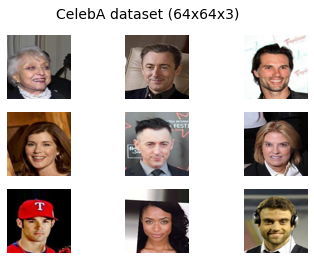

In [4]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape



def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues
    return np.load('../celebA/faces_20000.npy')

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()

from_images = True

if from_images:
    dataset = load_faces(20e3) # load directly from the .png images
else:
    dataset = load_real_samples() # load from .npy preprocessed dataset
    
print(dataset.shape)
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='CelebA dataset (64x64x3)', n=3)


# Functions below were provided by the IDL course
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim)) 
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model


## Variational Autoencoders (VAEs)
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

### Set up experiment to assess the performance of VAE with different parameters
We run a VAE for different *latent dimensions* and *batch sizes*. For each experiment we save the **learning curve** and an **image**.

In [5]:
def run_vae(latent_dim, batch_size, num_epochs=20):
    encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

    seed = np.random.seed(1998)
    latent_vector = np.random.randn(1, latent_dim)

    history = vae.fit(x=dataset, y=dataset, epochs=num_epochs, batch_size=batch_size)

    loss = np.array(history.history['loss'])
    image = decoder(latent_vector)[0,]

    labels = ['learning_curve','image']
    print('Saving...')
    for i,arr in enumerate([loss, image]):
        outname = '{:}_ld{:}_bs{:}.npy'.format(labels[i], latent_dim, batch_size)
        np.save(outname, arr)
        print(outname)
#         files.download(outname)

    return history

run_experiment = False
lds = [4, 8, 16, 32, 64, 128, 256]
bss = [1, 10, 40, 160, 320, 500]

if run_experiment:
    for ld in lds:
        for bs in bss:
            history = run_vae(ld, bs, num_epochs=5)

2022-11-16 11:02:24.966909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:02:25.133528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:02:25.134288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:02:25.135472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

2022-11-16 11:02:28.453765: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-11-16 11:02:29.884344: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-11-16 11:02:31.000424: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-11-16 11:02:31.799256: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-11-16 11:02:32.635674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-16 11:02:34.533025: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2000/2000 [==============================] - 29s 11ms/step - loss: 0.5802
Epoch 2/5
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5598
Epoch 3/5
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5563
Epoch 4/5
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5544
Epoch 5/5
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5534
Saving...
learning_curve_ld32_bs10.npy
image_ld32_bs10.npy


## Generate a VAE with the optimal parameters from the previous experiment

In [10]:
latent_dim = 32
batch_size = 10
num_epochs = 20
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

seed = np.random.seed(1998)
latent_vector = np.random.randn(1, latent_dim)

history = vae.fit(x=dataset, y=dataset, epochs=num_epochs, batch_size=batch_size)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 128)         147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

2022-11-16 11:09:12.155500: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.


Epoch 1/20
2000/2000 [==============================] - 22s 10ms/step - loss: 0.5844
Epoch 2/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5591
Epoch 3/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5559
Epoch 4/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5542
Epoch 5/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5535
Epoch 6/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5529
Epoch 7/20
2000/2000 [==============================] - 21s 11ms/step - loss: 0.5523
Epoch 8/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5519
Epoch 9/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5517
Epoch 10/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5513
Epoch 11/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.5510
Epoch 12/20
2000/2000 [==============================] - 21s 10

### Investigate the  relation between image features and the dimensions of the latent space 

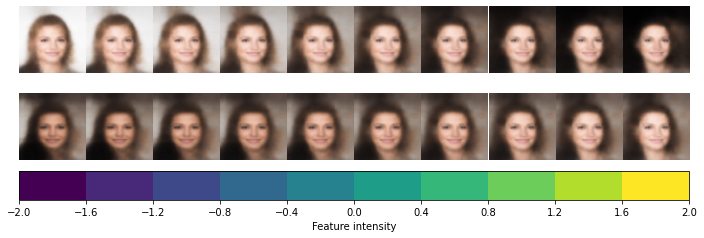

In [148]:
def image_evolution(decoder, latent_dim, ind, n_samples, ax=None):
    np.random.seed(42)
    vector = np.random.randn(1,latent_dim)
    vector[0][ind] = 1.

    
    factor = np.linspace(-2., 2., n_samples)
    for i in range(n_samples):
        new_vector = np.copy(vector)
        new_vector[0][ind] *= factor[i]
        image = decoder(new_vector)[0]

        ax[i].imshow(image)

# We identify the following relations:
# latent space dimension = feature
# 27 = background
# 31 = skin color

# plot the evolution of the images over 10 steps
n_samples = 10

fig, ax = plt.subplots(2,n_samples,figsize=(12,4))
image_evolution(decoder, 32, 27, n_samples, ax=ax[0,:])
image_evolution(decoder, 32, 31, n_samples, ax=ax[1,:])
[axs.axis('off') for axs in ax.flatten()]

# add colorbar 
cmap = mpl.cm.viridis
bounds = np.linspace(-2, 2., n_samples+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.subplots_adjust(hspace=0.001, wspace=0.01)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Feature intensity", aspect=23., pad=0.05,
            ticks=np.linspace(-2,2, n_samples+1))

plt.show()
fig.savefig('feature_intensity.png', dpi=200, bbox_inches='tight')